使用数据集Wine_Quality_Data.csv。该数据集包含葡萄酒的各种化学特性，例如酸度、糖分、pH 值和酒精度。它还包含一个质量指标（3-9，越高越好）和一个颜色（红色或白色）。


In [2]:
from __future__ import print_function
import os

import pandas as pd
import numpy as np
data_path = ['dataset']
filepath = os.sep.join(data_path + ['Wine_Quality_Data.csv'])
data = pd.read_csv(filepath, sep=',')#加载数据集


In [6]:
data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [5]:
#颜色 需要进行数值编码。
data.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
color                    object
dtype: object

In [7]:
#将颜色特征转换为整数。
data['color'] = data.color.replace('white',0).replace('red',1).astype(np.intp)

In [8]:
data.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
color                     int64
dtype: object

- 使用 StratifiedShuffleSplit 将数据拆分为按葡萄酒质量分层的训练集和测试集。
请保留拆分索引。

- 检查训练和测试数据集的每个质量级别的百分比组成。

In [9]:
feature_cols = [x for x in data.columns if x not in 'color']

from sklearn.model_selection import StratifiedShuffleSplit

 
# 创建了一个生成器
strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=1000, random_state=42)
#len(train_idx),len(test_idx) (5497, 1000)
# 从 生成器获取索引
train_idx, test_idx = next(strat_shuff_split.split(data[feature_cols], data['color']))

# 创建数据集
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'color']

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, 'color']

检查训练集和验证集的酒的质量等级

In [15]:
y_train.value_counts().sort_index()

0    4144
1    1353
Name: color, dtype: int64

In [11]:
y_test.value_counts(normalize=True).sort_index()

0    0.754
1    0.246
Name: color, dtype: float64

In [12]:
X_train.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
3627,8.9,0.21,0.34,7.1,0.037,33.0,150.0,0.99620,3.10,0.45,9.7,6
1932,6.5,0.28,0.34,9.9,0.038,30.0,133.0,0.99540,3.11,0.44,9.8,5
5055,6.0,0.39,0.13,1.2,0.042,60.0,172.0,0.99114,3.06,0.52,10.6,5
2372,6.1,0.27,0.30,16.7,0.039,49.0,172.0,0.99985,3.40,0.45,9.4,5
158,7.1,0.68,0.00,2.2,0.073,12.0,22.0,0.99690,3.48,0.50,9.3,5


- 拟合一个对最大深度、特征或叶子没有设定限制的决策树分类器。
- 确定存在多少个节点以及这个（非常大的）树的深度是多少。
- 使用决策树，测量训练和测试数据集中的预测误差。

根据预测误差的差异，观察

In [13]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train)

In [14]:
#节点数量和最大深度
dt.tree_.node_count, dt.tree_.max_depth

(171, 22)

In [16]:
#返回测量误差的函数
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred)},
                      name=label)


In [17]:
#决策树对训练数据的预测比测试数据好一点，这与（轻度）过度拟合一致。还要注意训练数据的召回分数。在许多情况下，这种预测差异都比这里看到的还要大。

 
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

train_test_full_error = pd.concat([measure_error(y_train, y_train_pred, 'train'),
                              measure_error(y_test, y_test_pred, 'test')],
                              axis=1)
train_test_full_error

,train,test
accuracy,0.999818,0.984000
precision,0.999261,0.963710
recall,1.000000,0.971545
f1,0.999631,0.967611


- 使用带有交叉验证的网格搜索，找到在测试数据集上表现良好的决策树。

- 确定节点的数量和这棵树的深度。

- 像以前一样测量训练集和测试集上的错误，并将它们与上面的树中的error值进行比较。

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features': range(1, len(dt.feature_importances_)+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

GR = GR.fit(X_train, y_train)

In [20]:
GR.best_estimator_.tree_.node_count, GR.best_estimator_.tree_.max_depth
#比较之前的(171, 22)

(99, 7)

In [21]:
#这些测试错误分数比之前的要好，前面的示例似乎对数据过度拟合，但只是略微过度。
y_train_pred_gr = GR.predict(X_train)
y_test_pred_gr = GR.predict(X_test)

train_test_gr_error = pd.concat([measure_error(y_train, y_train_pred_gr, 'train'),
                                 measure_error(y_test, y_test_pred_gr, 'test')],
                                axis=1)
train_test_gr_error

,train,test
accuracy,0.995816,0.989000
precision,0.998501,0.983539
recall,0.984479,0.971545
f1,0.991440,0.977505


- 将数据重新拆分为 X 和 y 部分，这一次使用residual_sugar作为预测 (y) 数据。

- 使用具有交叉验证的网格搜索，找到在测试数据集上表现良好的决策树回归模型。
- 使用均方误差MSE测量训练集和测试集上的误差。
- 绘制实际residual_sugar与预测residual_sugar图像。

In [22]:
feature_cols = [x for x in data.columns if x != 'residual_sugar']

# 使用之前的索引拆分
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'residual_sugar']

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, 'residual_sugar']

In [23]:
from sklearn.tree import DecisionTreeRegressor

dr = DecisionTreeRegressor().fit(X_train, y_train)

param_grid = {'max_depth':range(1, dr.tree_.max_depth+1, 2),
              'max_features': range(1, len(dr.feature_importances_)+1)}

GR_sugar = GridSearchCV(DecisionTreeRegressor(random_state=42),
                     param_grid=param_grid,
                     scoring='neg_mean_squared_error',
                      n_jobs=-1)

GR_sugar = GR_sugar.fit(X_train, y_train)

In [24]:
#节点数和树的最大深度。这棵树有很多节点，因为y是连续数据
GR_sugar.best_estimator_.tree_.node_count, GR_sugar.best_estimator_.tree_.max_depth

(2891, 13)

In [25]:
#训练和测试数据集上的错误。由于y是连续的，使用均方误差

from sklearn.metrics import mean_squared_error

y_train_pred_gr_sugar = GR_sugar.predict(X_train)
y_test_pred_gr_sugar  = GR_sugar.predict(X_test)

train_test_gr_sugar_error = pd.Series({'train': mean_squared_error(y_train, y_train_pred_gr_sugar),
                                         'test':  mean_squared_error(y_test, y_test_pred_gr_sugar)},
                                          name='MSE').to_frame().T

train_test_gr_sugar_error

,train,test
MSE,0.401886,3.204129


实际residual_sugar与预测residual_sugar的关系图。

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')
sns.set_palette('dark')

% matplotlib inline

[(0, 35), Text(0,0.5,'Predict'), (0, 35), Text(0.5,0,'Test')]

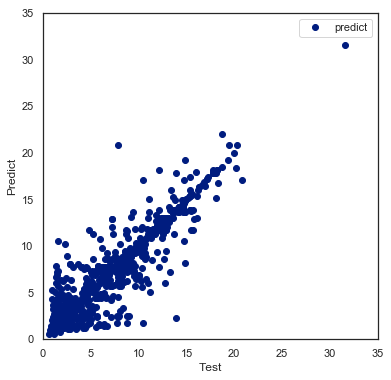

In [27]:
fig = plt.figure(figsize=(6,6))


ph_test_predict = pd.DataFrame({'test':y_test.values,
                                'predict': y_test_pred_gr_sugar}).set_index('test').sort_index()
ax = plt.axes()
ph_test_predict.plot(marker='o', ls='', ax=ax)
ax.set(xlabel='Test', ylabel='Predict', xlim=(0,35), ylim=(0,35))

In [30]:
ph_test_predict

,predict
test,
0.60,0.600
0.70,0.950
0.80,1.400
0.80,1.100
0.90,1.266
...,...
19.95,19.950
20.15,18.350
20.30,20.800


图像可视化需要一个额外的命令行程序 (GraphViz) 和 Python 库 (PyDotPlus)。 GraphViz 可以与 Linux 和 Mac 上的包管理器一起安装。对于 PyDotPlus，可以使用 pip 或 conda（conda install -c conda-forge pydotplus）来安装库。



下图一，其中预测了酒的颜色，并且特征和/或分割的数量不受限制。

下图二，其中预测了酒的颜色，但使用网格搜索来找到最佳深度和特征数量。

y为连续值的那颗决策树因为可能有太多节点无法可视化。

In [31]:
from io import StringIO
from IPython.display import Image, display

from sklearn.tree import export_graphviz

try:
    import pydotplus
    pydotplus_installed = True
    
except:
    print('PyDotPlus must be installed to execute the remainder of the cells associated with this question.')
    print('Please see the instructions for this question for details.')
    pydotplus_installed = False

In [32]:
feature_cols

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'chlorides',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality',
 'color']

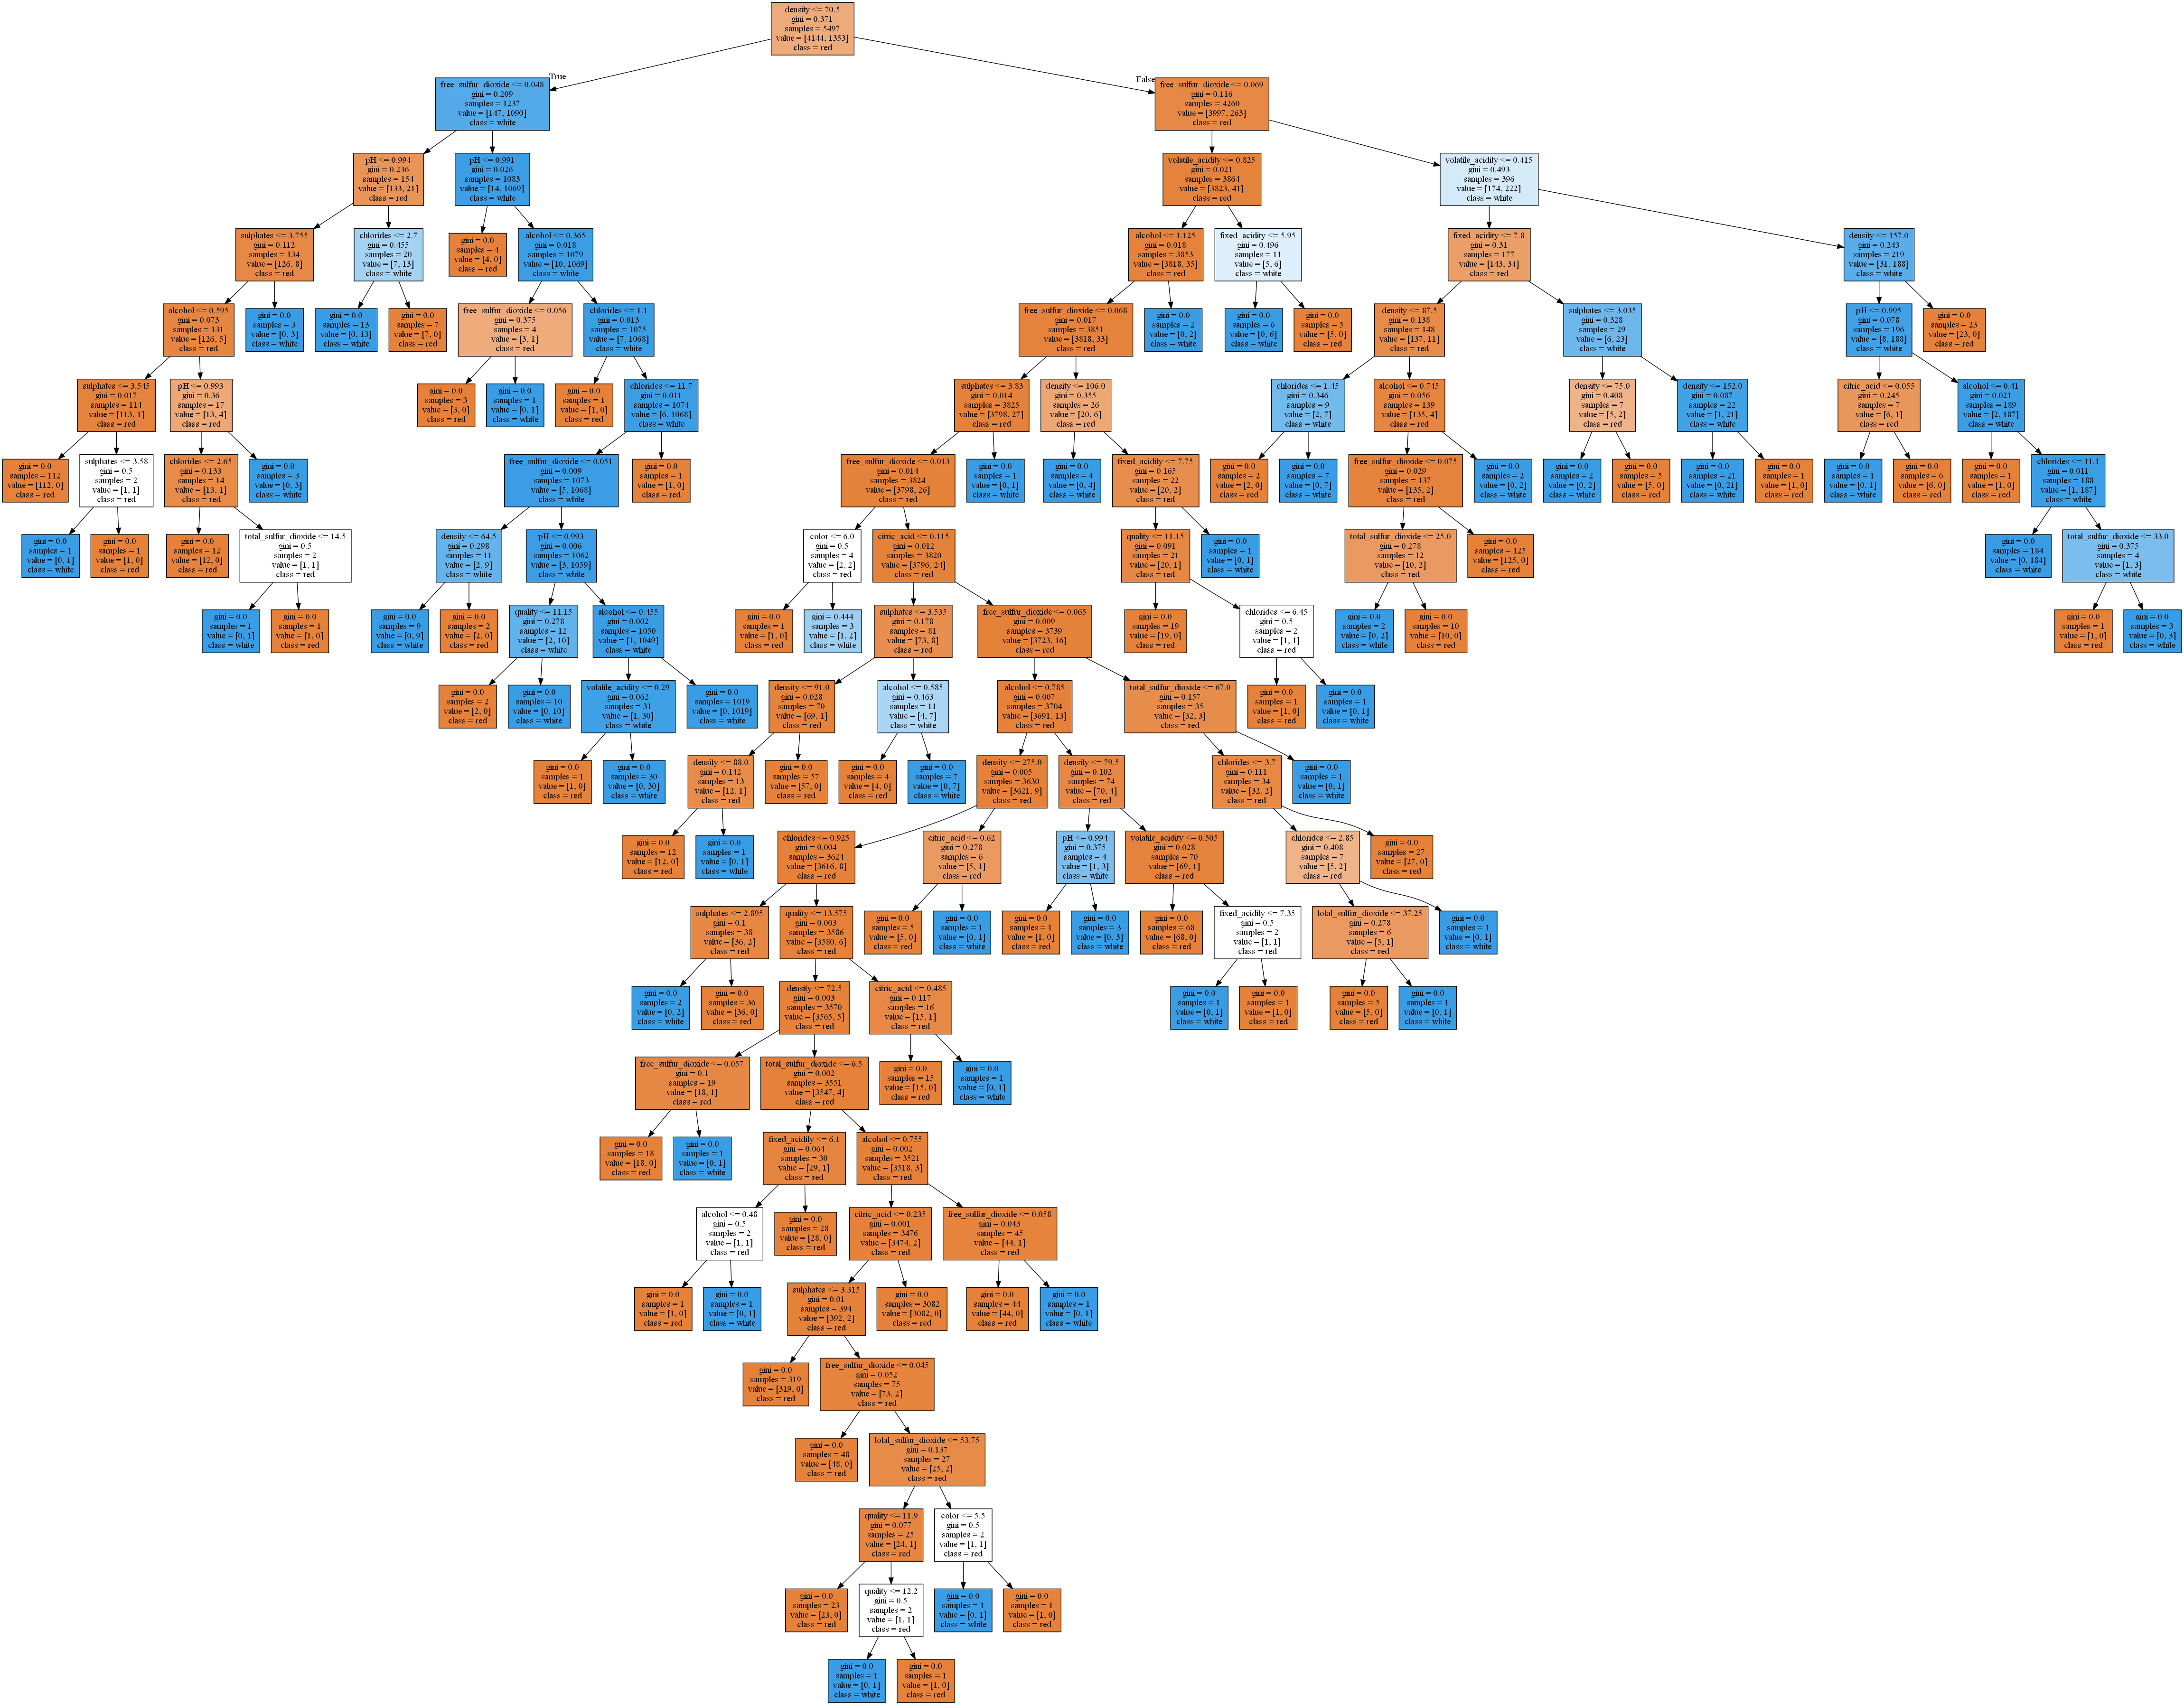

In [33]:
if pydotplus_installed:
    
   
    dot_data = StringIO()

    export_graphviz(dt, out_file=dot_data, feature_names= feature_cols,class_names=['red','white'],filled=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    print(graph)
    
    filename = 'wine_tree.png'
    graph.write_png(filename)
    img = Image(filename=filename)
    display(img)
    
else:
    print('This cell not executed because PyDotPlus could not be loaded.')

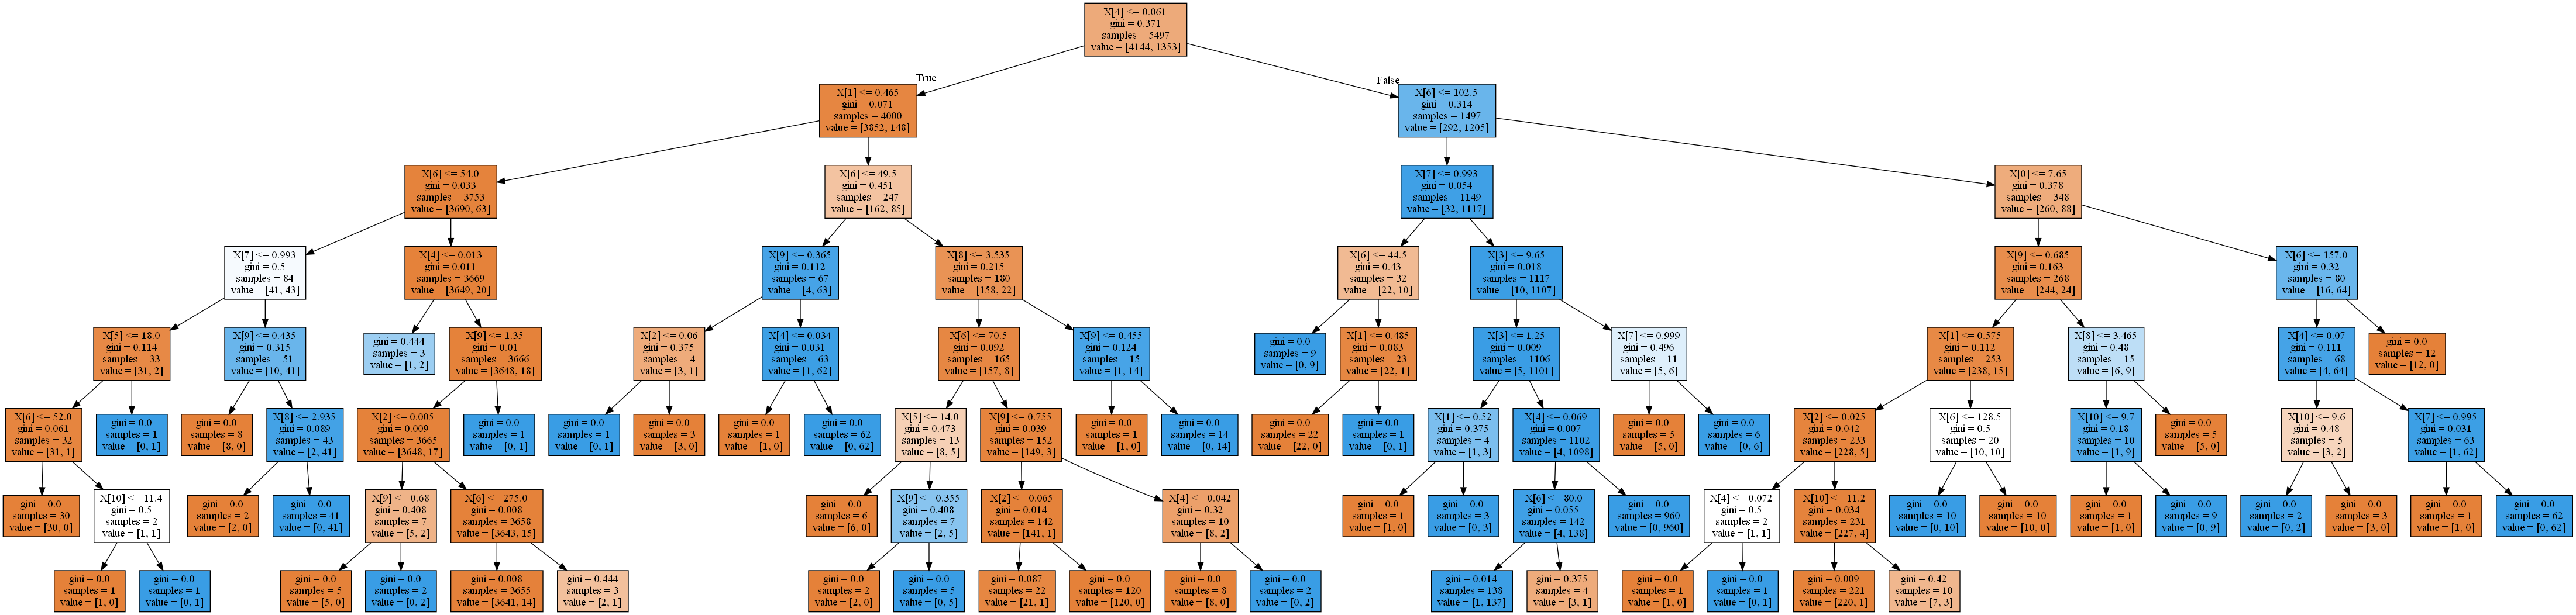

In [34]:
#这棵树比前一棵树浅得多。
if pydotplus_installed:
    
    # 创建文件输出目的地
    dot_data = StringIO()

    export_graphviz(GR.best_estimator_, out_file=dot_data, filled=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

    # 查看树图像
    filename = 'wine_tree_prune.png'
    graph.write_png(filename)
    img = Image(filename=filename) 
    display(img)
    
else:
    print('This cell not executed because PyDotPlus could not be loaded.')